In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats, spatial
import pickle

In [2]:
tfidf_path = '../../data/tfidf_toprev_conlen_full_v2/'

In [3]:
lda_path = '../../data/lda_jsd_toprev_conlen/'

In [4]:
fandom_list = [i for i in os.listdir(tfidf_path) if 'tsv' in i]

In [5]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(1000):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[24]
        head = sorted(aves)[975]
        return (ave_original, tail, head)

## Aggregate

In [6]:
def create_normed_dfs(df, field):

#     Normalize by log scale
    df = df.replace([np.inf, -np.inf], np.nan)
    df[field].fillna(0, inplace=True)

#     # turn into z scores
    if field == 'Comments':
        df[field] = np.log(df[field]+1)
        df = df.replace([np.inf, -np.inf], np.nan)
        df[field].dropna()
        df[field] = (df[field] - df[field].mean())/df[field].std(ddof=0)
    
    else:
        df[field] = df[field]/df['Chapters']
        df[field] = np.log(df[field]+0.001)
        df = df.replace([np.inf, -np.inf], np.nan)
        df[['Chapters',field ]].dropna()
        df[field] = (df[field] - df[field].mean())/df[field].std(ddof=0)

    return df

In [7]:
def create_dict(df, nov_field, suc_field, binsize):
    
    # Make bins
    df[nov_field] = df[nov_field].astype(float)
    vmin = min(df[nov_field].tolist())
    vmax = max(df[nov_field].tolist())
    dic = {}
    for i in np.arange(vmin, vmax, binsize):
        df_s = df[(df[nov_field] >= i) & (df[nov_field] < i+binsize)]
        li = df_s[suc_field].tolist()
        if len(li) > 0:
            dic[i] = bootstrap_resample(li)
    return dic

In [8]:
def generate_res(path, nov_field, suc_field, binsize):
    df_all = []
    fandom_list = [i for i in os.listdir(path) if 'tsv' in i]
    for i,fandom in enumerate(fandom_list):
        df = pd.read_csv(os.path.join(path,fandom), sep = '\t')
        df = create_normed_dfs(df, suc_field)
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df[[nov_field, suc_field]].dropna()
        df_all.append(df)

    df = pd.concat(df_all)
    df = df.sort_values(by = nov_field)[:-5]
    df = df.sort_values(by = suc_field)[:-5]
    dic = create_dict(df, nov_field, suc_field, binsize)

    return dic
    

In [9]:
lda_kudos_dict = generate_res(lda_path, 'JSD','Kudos', 0.05)
lda_hits_dict = generate_res(lda_path, 'JSD','Hits',0.05)
lda_comments_dict = generate_res(lda_path, 'JSD','Comments',0.05)
lda_bookmarks_dict = generate_res(lda_path, 'JSD','Bookmarks',0.05)

In [11]:
pickle.dump(lda_kudos_dict, open('lda_kudos_dict.p', 'wb'))
pickle.dump(lda_hits_dict, open('lda_hits_dict.p', 'wb'))
pickle.dump(lda_comments_dict, open('lda_comments_dict.p', 'wb'))
pickle.dump(lda_bookmarks_dict, open('lda_bookmarks_dict.p', 'wb'))

In [49]:
tfidf_kudos_dict = generate_res(tfidf_path, 'Cos', 'Kudos', 0.1)
tfidf_hits_dict = generate_res(tfidf_path, 'Cos', 'Hits', 0.1)
tfidf_comments_dict = generate_res(tfidf_path, 'Cos', 'Comments', 0.1)
tfidf_bookmarks_dict = generate_res(tfidf_path, 'Cos', 'Bookmarks', 0.1)

In [ ]:
pickle.dump(tfidf_kudos_dict, open('tfidf_kudos_dict.p', 'wb'))
pickle.dump(tfidf_hits_dict, open('tfidf_hits_dict.p', 'wb'))
pickle.dump(tfidf_comments_dict, open('tfidf_comments_dict.p', 'wb'))
pickle.dump(tfidf_bookmarks_dict, open('tfidf_bookmarks_dict.p', 'wb'))

In [4]:
lda_kudos_dict = pickle.load(open('lda_kudos_dict.p', 'rb'))
lda_hits_dict = pickle.load(open('lda_hits_dict.p', 'rb'))
lda_comments_dict = pickle.load(open('lda_comments_dict.p', 'rb'))
lda_bookmarks_dict = pickle.load(open('lda_bookmarks_dict.p', 'rb'))

In [5]:
tfidf_kudos_dict = pickle.load(open('tfidf_kudos_dict.p', 'rb'))
tfidf_hits_dict = pickle.load(open('tfidf_hits_dict.p', 'rb'))
tfidf_comments_dict = pickle.load(open('tfidf_comments_dict.p', 'rb'))
tfidf_bookmarks_dict = pickle.load(open('tfidf_bookmarks_dict.p', 'rb'))

In [6]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

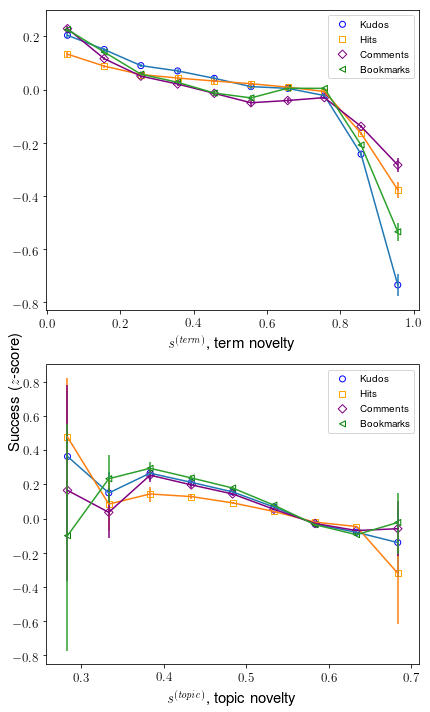

In [24]:
fig = plt.figure(figsize=(6,10))


plt.subplot(2, 1, 1)

tfidf_kudos_x = sorted(tfidf_kudos_dict.keys())
tfidf_kudos_y = [tfidf_kudos_dict[j][0] for j in tfidf_kudos_x]
lower_error = [tfidf_kudos_dict[j][0] - tfidf_kudos_dict[j][1] for j in tfidf_kudos_x]
upper_error = [tfidf_kudos_dict[j][2] - tfidf_kudos_dict[j][0] for j in tfidf_kudos_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_kudos_x, tfidf_kudos_y, yerr=asymmetric_error)
plt.scatter(tfidf_kudos_x, tfidf_kudos_y, label = 'Kudos',facecolor='none',edgecolor='blue')

tfidf_hits_x = sorted(tfidf_hits_dict.keys())
tfidf_hits_y = [tfidf_hits_dict[j][0] for j in tfidf_hits_x]
lower_error = [tfidf_hits_dict[j][0] - tfidf_hits_dict[j][1] for j in tfidf_hits_x]
upper_error = [tfidf_hits_dict[j][2] - tfidf_hits_dict[j][0] for j in tfidf_hits_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_hits_x, tfidf_hits_y, yerr=asymmetric_error)
plt.scatter(tfidf_hits_x, tfidf_hits_y,marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

tfidf_comments_x = sorted(tfidf_comments_dict.keys())
tfidf_comments_y = [tfidf_comments_dict[j][0] for j in tfidf_comments_x]
lower_error = [tfidf_comments_dict[j][0] - tfidf_comments_dict[j][1] for j in tfidf_comments_x]
upper_error = [tfidf_comments_dict[j][2] - tfidf_comments_dict[j][0] for j in tfidf_comments_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_comments_x, tfidf_comments_y, yerr=asymmetric_error,c='purple')
plt.scatter(tfidf_comments_x, tfidf_comments_y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

tfidf_bookmarks_x = sorted(tfidf_bookmarks_dict.keys())
tfidf_boomkarks_y = [tfidf_bookmarks_dict[j][0] for j in tfidf_bookmarks_x]
lower_error = [tfidf_bookmarks_dict[j][0] - tfidf_bookmarks_dict[j][1] for j in tfidf_bookmarks_x]
upper_error = [tfidf_bookmarks_dict[j][2] - tfidf_bookmarks_dict[j][0] for j in tfidf_bookmarks_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_bookmarks_x, tfidf_boomkarks_y, yerr=asymmetric_error)
plt.scatter(tfidf_bookmarks_x, tfidf_boomkarks_y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')
""
plt.legend()
plt.xlabel('$\it{s}^{(term)}$, term novelty',fontsize=15)
# plt.ylabel('Success ($\it{z}$-score)',fontsize=15)
plt.tick_params(labelsize=13)

fig.text(0.03, 0.45, 'Success ($\it{z}$-score)', ha='center', va='center', rotation='vertical', fontsize=15)

plt.subplot(2, 1, 2)

# for dic in [lda_kudos_dict, lda_hits_dict, lda_comments_dict, lda_bookmarks_dict]:

lda_kudos_x = sorted(lda_kudos_dict.keys())
lda_kudos_y = [lda_kudos_dict[j][0] for j in lda_kudos_x]
lower_error = [lda_kudos_dict[j][0] - lda_kudos_dict[j][1] for j in lda_kudos_x]
upper_error = [lda_kudos_dict[j][2] - lda_kudos_dict[j][0] for j in lda_kudos_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_kudos_x, lda_kudos_y, yerr=asymmetric_error)
plt.scatter(lda_kudos_x, lda_kudos_y,label = 'Kudos',facecolor='none',edgecolor='blue')

lda_hits_x = sorted(lda_hits_dict.keys())
lda_hits_y = [lda_hits_dict[j][0] for j in lda_hits_x]
lower_error = [lda_hits_dict[j][0] - lda_hits_dict[j][1] for j in lda_hits_x]
upper_error = [lda_hits_dict[j][2] - lda_hits_dict[j][0] for j in lda_hits_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_hits_x, lda_hits_y, yerr=asymmetric_error)
plt.scatter(lda_hits_x, lda_hits_y,marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

lda_comments_x = sorted(lda_comments_dict.keys())
lda_comments_y = [lda_comments_dict[j][0] for j in lda_comments_x]
lower_error = [lda_comments_dict[j][0] - lda_comments_dict[j][1] for j in lda_comments_x]
upper_error = [lda_comments_dict[j][2] - lda_comments_dict[j][0] for j in lda_comments_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_comments_x, lda_comments_y, yerr=asymmetric_error, c='purple')
plt.scatter(lda_comments_x, lda_comments_y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

lda_bookmarks_x = sorted(lda_bookmarks_dict.keys())
lda_bookmarks_y = [lda_bookmarks_dict[j][0] for j in lda_bookmarks_x]
lower_error = [lda_bookmarks_dict[j][0] - lda_bookmarks_dict[j][1] for j in lda_bookmarks_x]
upper_error = [lda_bookmarks_dict[j][2] - lda_bookmarks_dict[j][0] for j in lda_bookmarks_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_bookmarks_x, lda_bookmarks_y, yerr=asymmetric_error )
plt.scatter(lda_bookmarks_x, lda_bookmarks_y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')
plt.tick_params(labelsize=13)

plt.legend()
plt.xlabel('$\it{s}^{(topic)}$, topic novelty', fontsize = 15)
plt.tight_layout()
plt.savefig('scatter_all_log.pdf', type='pdf')


### More plots

In [6]:
df_all = pd.read_csv('fanfic_regression_data_curated.tsv', sep = '\t')

In [7]:
len(df_all)

609812

In [10]:
df_all.columns.values

array(['Bookmarks', 'ChapterIndex', 'Chapters', 'Comments', 'Hits',
       'Kudos', 'Words', 'Term_novelty', 'Topic_novelty',
       'Freq_relationship', 'Category_F_F', 'Category_F_M',
       'Category_Gen', 'Category_M_M', 'Category_Multi', 'Category_Other',
       'Category_Unknown', 'ArchiveWarnings_underage',
       'ArchiveWarnings_death', 'ArchiveWarnings_choose_no',
       'ArchiveWarnings_no_apply', 'ArchiveWarnings_violence',
       'ArchiveWarnings_noncon', 'author_fic_cnt', 'Rating_E', 'Rating_G',
       'Rating_M', 'Rating_N', 'Rating_T', 'Fandom_harry_potter',
       'Fandom_dcu', 'Fandom_doctor_who', 'Fandom_star_wars',
       'Fandom_arthurian', 'Fandom_supernatural', 'Fandom_haikyuu',
       'Fandom_kuroko_no_basuke', 'Fandom_hamilton_miranda',
       'Fandom_dragon_age', 'Fandom_the_walking_dead', 'Fandom_buffy',
       'Fandom_les_miserables', 'Fandom_naruto', 'Fandom_tolkien',
       'Fandom_shakespare', 'Fandom_hetalia', 'Fandom_attack_on_titan',
       'Fandom_ms_

In [9]:
df_all.sort_values('Topic_novelty').col

,Bookmarks,ChapterIndex,Chapters,Comments,Hits,Kudos,Words,Term_novelty,Topic_novelty,Freq_relationship,...,Fandom_tolkien,Fandom_shakespare,Fandom_hetalia,Fandom_attack_on_titan,Fandom_ms_paint_adventures,Fandom_marvel,Fandom_sailor_moon,Fandom_one_direction,Fandom_sherlock,History
529468,0.090909,2.0,11,0,43.090909,1.545455,2260.000000,0.130726,0.283406,0,...,0,0,0,0,0,0,0,1,0,1451.0
528496,0.333333,3.0,3,4,645.000000,8.000000,1267.333333,0.458147,0.307730,0,...,0,0,0,0,0,0,1,0,0,1518.0
2134,6.000000,0.0,1,1,1022.000000,49.000000,1535.000000,0.360937,0.308467,0,...,0,0,0,0,0,0,0,0,0,4356.0
121964,0.000000,1.0,2,0,275.500000,0.500000,1687.500000,0.918170,0.324476,1,...,0,0,0,0,0,0,0,0,0,1438.0
135244,0.000000,0.0,1,0,260.000000,8.000000,1399.000000,0.338412,0.327295,1,...,0,0,0,0,0,0,0,0,0,3118.0


/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in l

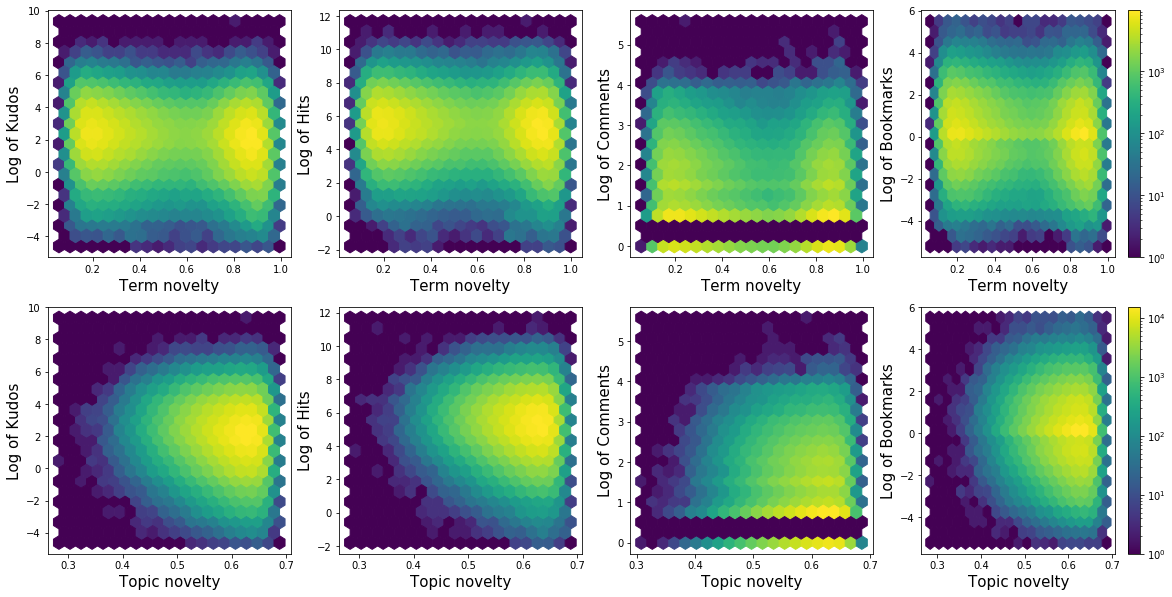

In [8]:
fig = plt.figure(figsize=(20,10))
gridsize = 20

plt.subplot(2, 4, 1)
p1 = plt.hexbin(df_all.Term_novelty, np.log(df_all.Kudos), bins='log', gridsize=gridsize)
plt.xlabel('Term novelty', fontsize=15)
plt.ylabel('Log of Kudos', fontsize=15)

plt.subplot(2, 4, 2)
p2 = plt.hexbin(df_all.Term_novelty, np.log(df_all.Hits), bins='log', gridsize=gridsize)
plt.xlabel('Term novelty', fontsize=15)
plt.ylabel('Log of Hits', fontsize=15)

plt.subplot(2, 4, 3)
p3 = plt.hexbin(df_all.Term_novelty, np.log(df_all.Comments), bins='log', gridsize=gridsize)
plt.xlabel('Term novelty', fontsize=15)
plt.ylabel('Log of Comments', fontsize=15)

plt.subplot(2, 4, 4)
p4 = plt.hexbin(df_all.Term_novelty, np.log(df_all.Bookmarks), bins='log', gridsize=gridsize)
cb = plt.colorbar(p4)
plt.xlabel('Term novelty', fontsize=15)
plt.ylabel('Log of Bookmarks', fontsize=15)

plt.subplot(2, 4, 5)
p5 = plt.hexbin(df_all.Topic_novelty, np.log(df_all.Kudos), bins='log', gridsize=gridsize)
plt.xlabel('Topic novelty', fontsize=15)
plt.ylabel('Log of Kudos', fontsize=15)

plt.subplot(2, 4, 6)
p6 = plt.hexbin(df_all.Topic_novelty, np.log(df_all.Hits), bins='log', gridsize=gridsize)
plt.xlabel('Topic novelty', fontsize=15)
plt.ylabel('Log of Hits', fontsize=15)

plt.subplot(2, 4, 7)
p7 = plt.hexbin(df_all.Topic_novelty, np.log(df_all.Comments), bins='log', gridsize=gridsize)
plt.xlabel('Topic novelty', fontsize=15)
plt.ylabel('Log of Comments', fontsize=15)

plt.subplot(2, 4, 8)
p8 = plt.hexbin(df_all.Topic_novelty, np.log(df_all.Bookmarks), bins='log', gridsize=gridsize)
cb = plt.colorbar(p8)
plt.xlabel('Topic novelty', fontsize=15)
plt.ylabel('Log of Bookmarks', fontsize=15)

plt.savefig('vars_hexbin.png', format='png')

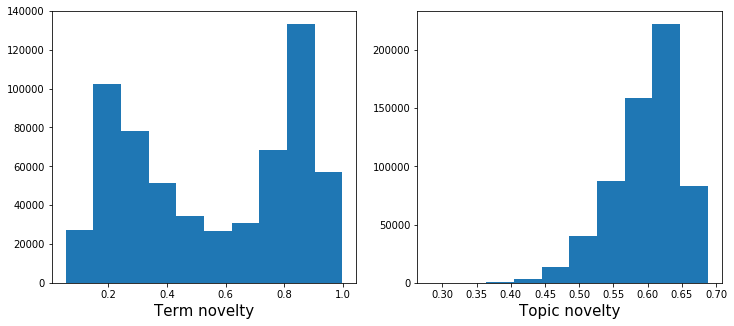

In [48]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(df_all.Term_novelty)
plt.xlabel('Term novelty', fontsize=15)
plt.subplot(1,2,2)
plt.hist(df_all.Topic_novelty)
plt.xlabel('Topic novelty', fontsize=15)
plt.savefig('novelty_dist.png', format='png')

In [127]:
term_n = sorted(df_all['Term_novelty'].tolist())
term_n = np.quantile(term_n, [0.25, 0.50, 0.75])
term_n = np.insert(term_n, 0, 0)
term_n = np.concatenate([term_n, [1]])

In [128]:
term_n

array([0.        , 0.26859697, 0.56553247, 0.83976825, 1.        ])

/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


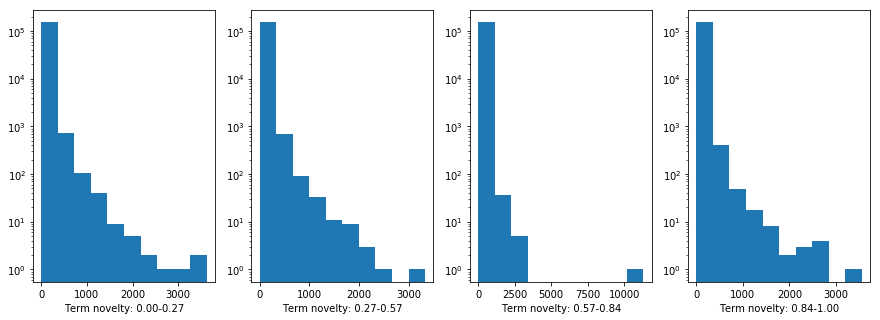

In [132]:
plt.figure(figsize=(15,5))
for i in range(len(term_n)-1):
    df_s = df_all[(df_all['Term_novelty'] >= term_n[i]) & (df_all['Term_novelty'] < term_n[i+1])]
    plt.subplot(1,4,i+1)
    plt.hist(df_s.Kudos)
    plt.yscale('log')
    plt.xlabel('Term novelty: {0:.2f}-{1:.2f}'.format(term_n[i], term_n[i+1]) )
# plt.savefig('term_binned_kudos_dist.png', format='png')

/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


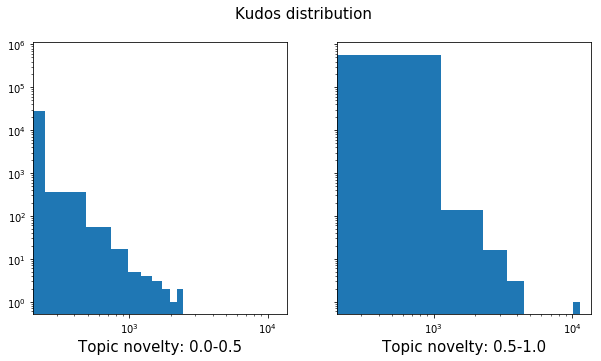

In [100]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10,5))
f.suptitle('Kudos distribution', fontsize=15)
df_1 = df_all[(df_all['Topic_novelty'] >= r[0]) & (df_all['Topic_novelty'] < r[1])]
ax1.hist(df_1.Kudos)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Topic novelty: {0:.1f}-{1:.1f}'.format(r[0], r[1]), fontsize=15 )

df_2 = df_all[(df_all['Topic_novelty'] >= r[1]) & (df_all['Topic_novelty'] < r[2])]
ax2.hist(df_2.Kudos)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Topic novelty: {0:.1f}-{1:.1f}'.format(r[1], r[2]), fontsize=15 )
plt.savefig('topic_binned_kudos_dist.png', format='png')

In [80]:
fandoms_nov = {}
for i,fandom in enumerate(fandom_list):
    df = pd.read_csv(os.path.join(lda_path,fandom), sep = '\t')
    fandoms_nov[fandom.replace('_temporal_lda_jsd_toprev_full.tsv', '')] = np.average(df.JSD.tolist())


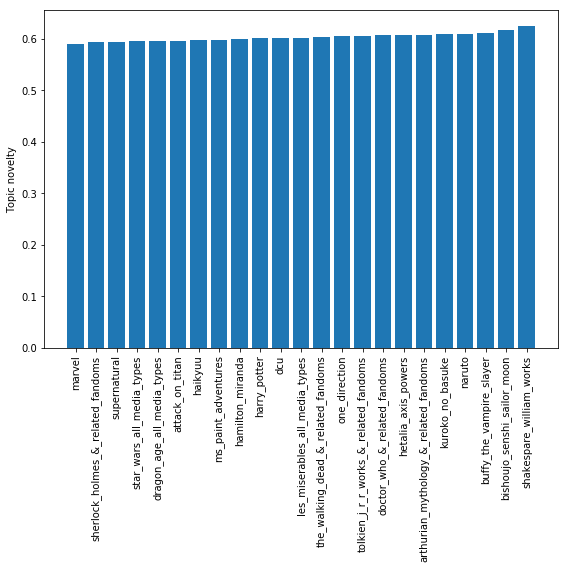

In [81]:
xlabs = sorted(fandoms_nov, key=fandoms_nov.get)
x = np.arange(len(xlabs))
y = [fandoms_nov[k] for k in xlabs]
plt.figure(figsize=(8, 8))
plt.bar(x, y)
plt.xticks(x, xlabs, rotation=90)
plt.ylabel('Topic novelty')
plt.tight_layout()
plt.savefig('fandoms_sort_topic_novelty.png', type='png')

/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


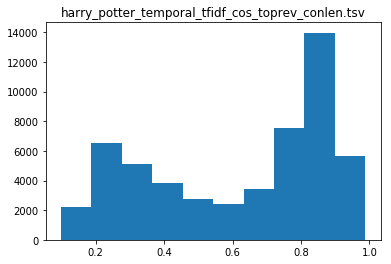

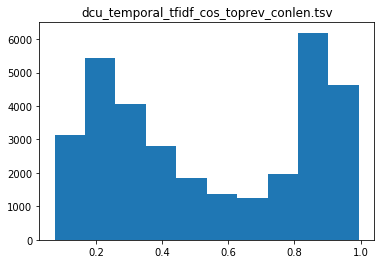

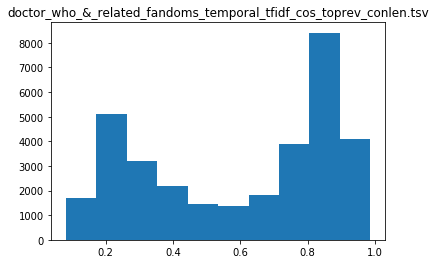

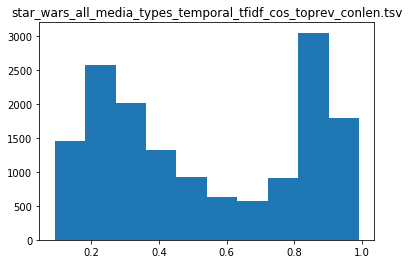

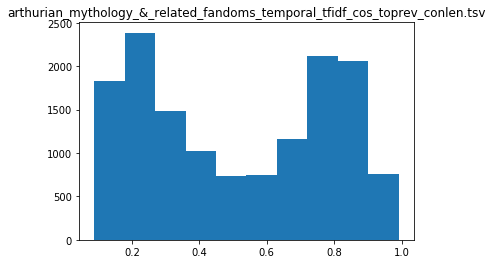

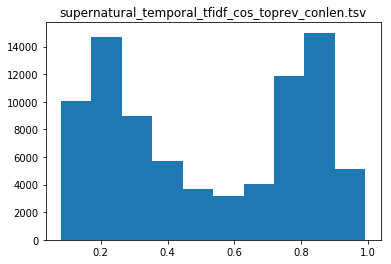

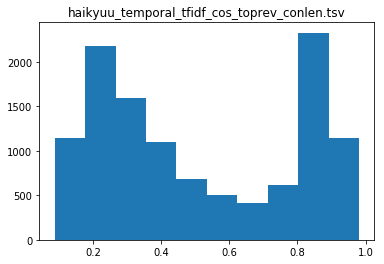

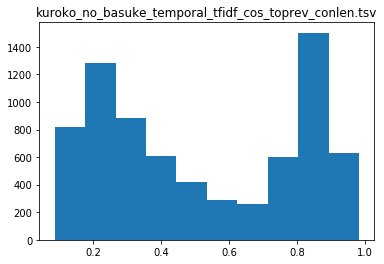

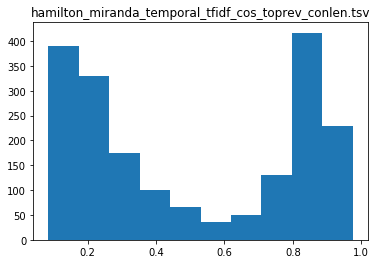

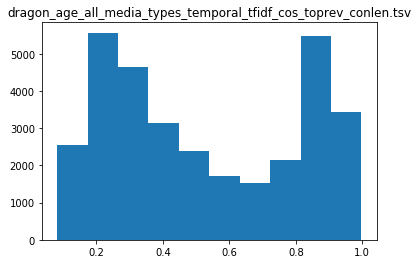

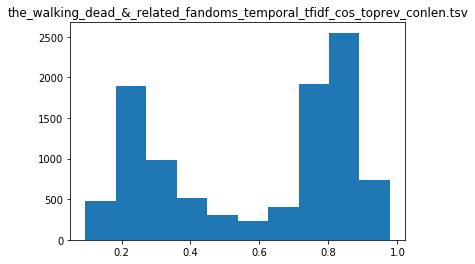

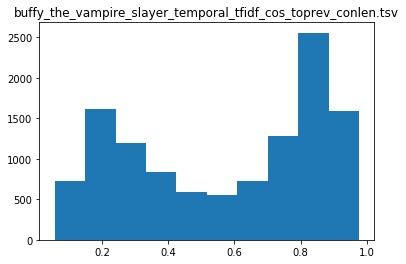

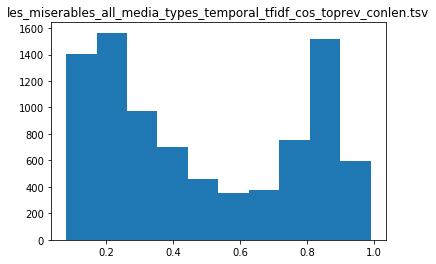

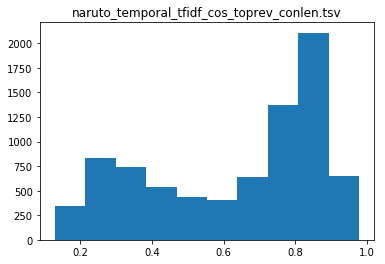

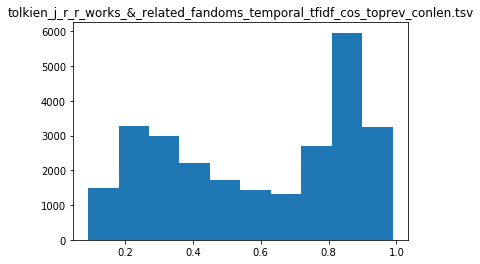

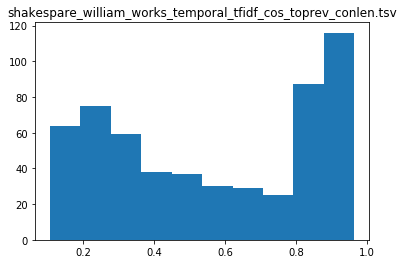

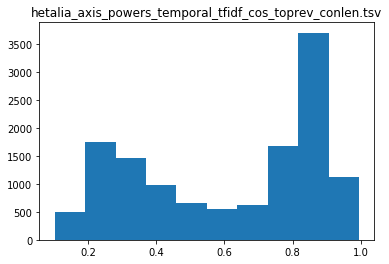

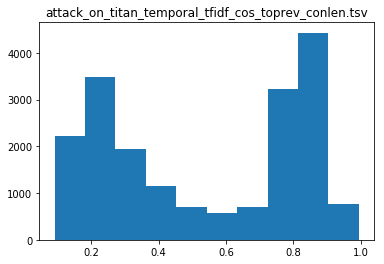

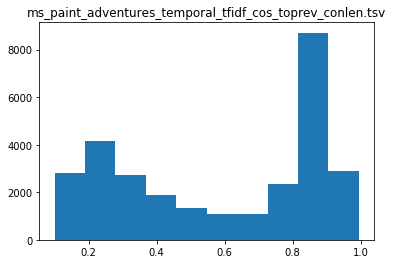

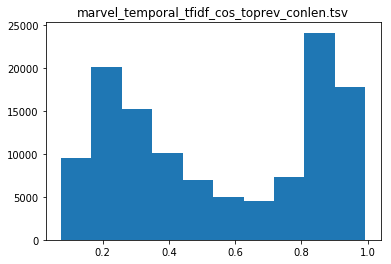

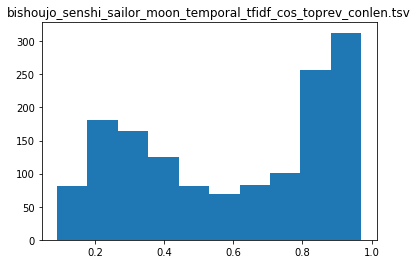

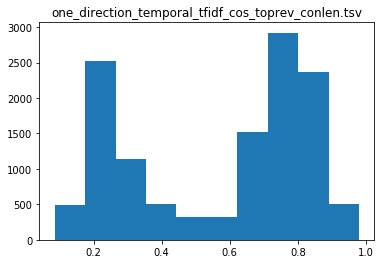

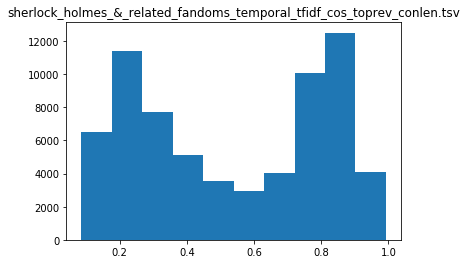

In [107]:
fandoms_nov = {}
for i,fandom in enumerate(fandom_list):
    df = pd.read_csv(os.path.join(tfidf_path,fandom), sep = '\t')
    plt.figure()
    plt.hist(df.Cos)
    plt.title(fandom.replace('_temporal_tfidf_jsd_toprev_conlen.tsv', ''))


In [ ]:
df_al